In [3]:
import sys
import os

sys.path.append(os.path.abspath("../"))

from src.paths import RAW_DATA_electricity_DIR

ModuleNotFoundError: No module named 'src'

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
from src.paths import MODELS_DIR

In [15]:
import src.component.feature_group_config as config
from comet_ml import Experiment

In [16]:
import hopsworks

# connect to the project
project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME,
    api_key_value=config.HOPSWORKS_API_KEY
)

# connect to the feature store
feature_store = project.get_feature_store()

# connect to the feature group
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION,
)

2025-04-11 14:40:32,340 INFO: Initializing external client
2025-04-11 14:40:32,341 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-04-11 14:40:33,011 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1222815


In [17]:
import hopsworks 
project = hopsworks.login()
fs = project.get_feature_store(name='mix_featurestore')
fg = fs.get_feature_group('electricity_demand_feature_group', version=1)

2025-04-11 14:40:33,531 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-04-11 14:40:33,535 INFO: Initializing external client
2025-04-11 14:40:33,536 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-04-11 14:40:33,987 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1222815


In [18]:
df = fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.66s) 


In [19]:
df.head()

,date,sub_region_code,demand,temperature_2m
0,2024-04-18 17:00:00+00:00,1,850,13.858500
1,2024-08-10 11:00:00+00:00,8,524,23.908501
2,2024-04-08 19:00:00+00:00,8,505,11.058500
3,2024-09-21 20:00:00+00:00,4,627,13.808500
4,2024-03-08 20:00:00+00:00,1,1235,1.558500


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96525 entries, 0 to 96524
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype                  
---  ------           --------------  -----                  
 0   date             96525 non-null  datetime64[us, Etc/UTC]
 1   sub_region_code  96525 non-null  int64                  
 2   demand           96525 non-null  object                 
 3   temperature_2m   96525 non-null  float32                
dtypes: datetime64[us, Etc/UTC](1), float32(1), int64(1), object(1)
memory usage: 2.6+ MB


In [21]:
# create feature view (if it doesn't exist yet)
# This feature view only uses on feature group, so the query is trivial
try:
    # create feature view if it doesn't exist yet
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all()
    )
except:
    print('Feature view already existed. Skip creation.')

Feature view already existed. Skip creation.


In [22]:
# get feature view
feature_view = feature_store.get_feature_view(
    name=config.FEATURE_VIEW_NAME,
    version=config.FEATURE_VIEW_VERSION
)

In [23]:
data, _ = feature_view.training_data(
    description='Time-series hourly electricity demand values',
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.60s) 


In [24]:
data.head()

,date,sub_region_code,demand,temperature_2m
0,2024-04-18 17:00:00+00:00,1,850,13.858500
1,2024-08-10 11:00:00+00:00,8,524,23.908501
2,2024-04-08 19:00:00+00:00,8,505,11.058500
3,2024-09-21 20:00:00+00:00,4,627,13.808500
4,2024-03-08 20:00:00+00:00,1,1235,1.558500


In [25]:
sub_region_unique = data["sub_region_code"].unique()
sub_region_unique

array([ 1,  8,  4,  5,  6,  2,  0,  9,  3,  7, 10])

In [26]:
df_sub_0 = data[data["sub_region_code"] == 0]
df_sub_0.head()

,date,sub_region_code,demand,temperature_2m
10,2024-10-13 06:00:00+00:00,0,1370,7.2085
22,2024-11-03 03:00:00+00:00,0,1548,9.2585
56,2024-11-25 16:00:00+00:00,0,1870,0.6585
62,2024-10-10 15:00:00+00:00,0,1585,15.3585
64,2024-05-23 18:00:00+00:00,0,1493,16.9585


In [27]:
# sort by `pickup_location_id` and `pickup_hour`
df_sub_0.sort_values(by=['date'], inplace=True)
df_sub_0

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date,sub_region_code,demand,temperature_2m
16049,2024-01-01 04:00:00+00:00,0,1516,12.2585
20802,2024-01-01 05:00:00+00:00,0,1450,11.8585
20725,2024-01-01 06:00:00+00:00,0,1384,12.0585
75386,2024-01-01 07:00:00+00:00,0,1351,12.3585
42482,2024-01-01 08:00:00+00:00,0,1335,11.8085
...,...,...,...,...
75666,2024-12-31 14:00:00+00:00,0,1912,4.8585
39664,2024-12-31 15:00:00+00:00,0,1926,4.8585
89958,2024-12-31 16:00:00+00:00,0,1942,4.9585
19780,2024-12-31 17:00:00+00:00,0,1952,5.1085


In [28]:
df_sub_0.drop(['sub_region_code', 'temperature_2m'], axis=1, inplace=True)

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [29]:
df_sub_0.iloc[:20]

,date,demand
16049,2024-01-01 04:00:00+00:00,1516
20802,2024-01-01 05:00:00+00:00,1450
20725,2024-01-01 06:00:00+00:00,1384
75386,2024-01-01 07:00:00+00:00,1351
42482,2024-01-01 08:00:00+00:00,1335
27310,2024-01-01 09:00:00+00:00,1334
71790,2024-01-01 10:00:00+00:00,1341
16971,2024-01-01 11:00:00+00:00,1375
6937,2024-01-01 12:00:00+00:00,1425
30994,2024-01-01 13:00:00+00:00,1486


In [30]:
df = df_sub_0.copy()

In [31]:
df['demand'] = pd.to_numeric(df['demand'])
df['date'] = pd.to_datetime(df['date'])

In [32]:
df = df.set_index('date')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8775 entries, 2024-01-01 04:00:00+00:00 to 2024-12-31 18:00:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   demand  8775 non-null   int64
dtypes: int64(1)
memory usage: 137.1 KB


In [34]:
print(df)

                           demand
date                             
2024-01-01 04:00:00+00:00    1516
2024-01-01 05:00:00+00:00    1450
2024-01-01 06:00:00+00:00    1384
2024-01-01 07:00:00+00:00    1351
2024-01-01 08:00:00+00:00    1335
...                           ...
2024-12-31 14:00:00+00:00    1912
2024-12-31 15:00:00+00:00    1926
2024-12-31 16:00:00+00:00    1942
2024-12-31 17:00:00+00:00    1952
2024-12-31 18:00:00+00:00    1961

[8775 rows x 1 columns]


In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler

colors = cycler(color=plt.get_cmap("tab10").colors)  # ["b", "r", "g"]

mpl.style.use("ggplot")
mpl.rcParams["figure.figsize"] = (20, 5)
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "lightgray"
mpl.rcParams["axes.prop_cycle"] = colors
mpl.rcParams["axes.linewidth"] = 1
mpl.rcParams["xtick.color"] = "black"
mpl.rcParams["ytick.color"] = "black"
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.titlesize"] = 25
mpl.rcParams["figure.dpi"] = 100


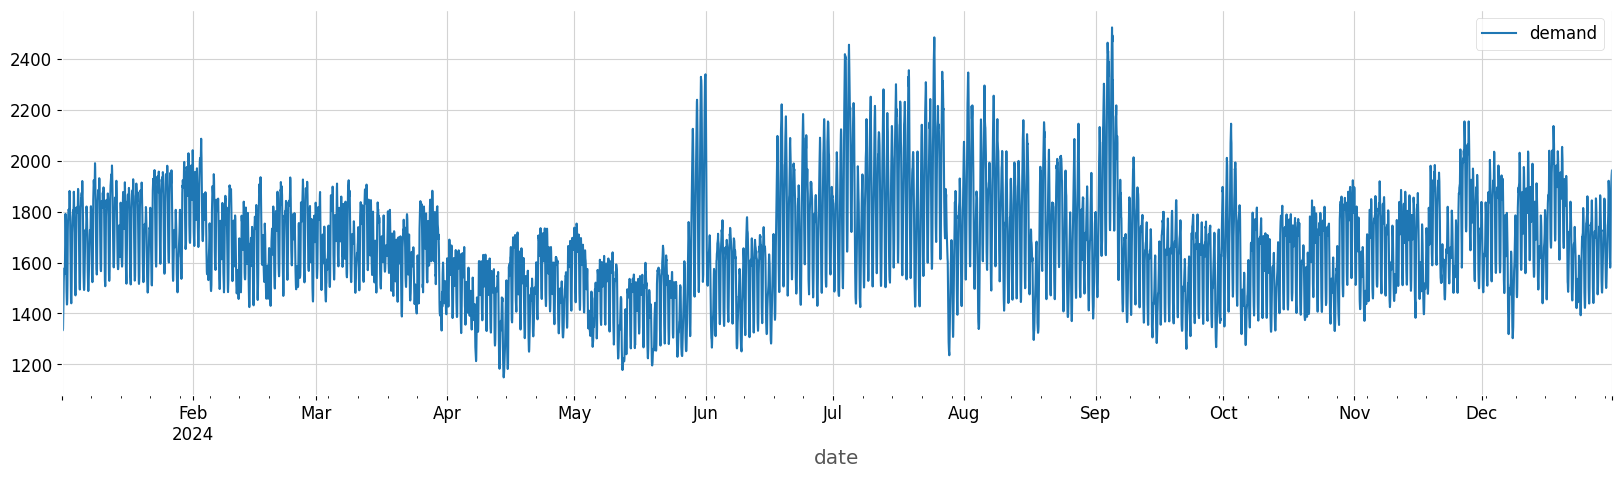

In [36]:
import matplotlib.pyplot as plt

df[['demand']].plot()
plt.show()

In [37]:
total_rows = len(df)
train_size = int(0.7 * total_rows)
val_size = int(0.15 * total_rows)
test_size = total_rows - train_size - val_size

In [38]:
train_set = df[:train_size]
print(train_set.head())

                           demand
date                             
2024-01-01 04:00:00+00:00    1516
2024-01-01 05:00:00+00:00    1450
2024-01-01 06:00:00+00:00    1384
2024-01-01 07:00:00+00:00    1351
2024-01-01 08:00:00+00:00    1335


In [39]:
val_set = df[train_size: train_size + val_size]
print(val_set.head())

                           demand
date                             
2024-09-13 02:00:00+00:00    1690
2024-09-13 03:00:00+00:00    1592
2024-09-13 04:00:00+00:00    1493
2024-09-13 05:00:00+00:00    1436
2024-09-13 06:00:00+00:00    1398


In [40]:
test_set = df[train_size + val_size:]
print(test_set.head())

                           demand
date                             
2024-11-06 22:00:00+00:00    1869
2024-11-06 23:00:00+00:00    1919
2024-11-07 00:00:00+00:00    1901
2024-11-07 01:00:00+00:00    1862
2024-11-07 02:00:00+00:00    1811


In [41]:
from sklearn.preprocessing import MinMaxScaler
#try different scalers
scaler = MinMaxScaler(feature_range=(0,1))
# train_set['load_scaled'] = scaler.fit_transform(train_set[['actual_load']])
train_set.loc[:, 'demand_scaled'] = scaler.fit_transform(train_set[['demand']])

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [42]:
import joblib

# Save the fitted scaler
joblib.dump(scaler, 'models/minmax_scaler.pkl')

['models/minmax_scaler.pkl']

In [43]:
train_set

,demand,demand_scaled
date,,
2024-01-01 04:00:00+00:00,1516,0.267103
2024-01-01 05:00:00+00:00,1450,0.219068
2024-01-01 06:00:00+00:00,1384,0.171033
2024-01-01 07:00:00+00:00,1351,0.147016
2024-01-01 08:00:00+00:00,1335,0.135371
...,...,...
2024-09-12 21:00:00+00:00,1694,0.396652
2024-09-12 22:00:00+00:00,1720,0.415575
2024-09-12 23:00:00+00:00,1734,0.425764


In [44]:
val_set.loc[:,'demand_scaled'] = scaler.transform(val_set[['demand']])

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [45]:
val_set

,demand,demand_scaled
date,,
2024-09-13 02:00:00+00:00,1690,0.393741
2024-09-13 03:00:00+00:00,1592,0.322416
2024-09-13 04:00:00+00:00,1493,0.250364
2024-09-13 05:00:00+00:00,1436,0.208879
2024-09-13 06:00:00+00:00,1398,0.181223
...,...,...
2024-11-06 17:00:00+00:00,1801,0.474527
2024-11-06 18:00:00+00:00,1817,0.486172
2024-11-06 19:00:00+00:00,1833,0.497817


In [46]:
test_set.loc[:, 'demand_scaled'] = scaler.transform(test_set[['demand']])

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [47]:
test_set

,demand,demand_scaled
date,,
2024-11-06 22:00:00+00:00,1869,0.524017
2024-11-06 23:00:00+00:00,1919,0.560408
2024-11-07 00:00:00+00:00,1901,0.547307
2024-11-07 01:00:00+00:00,1862,0.518923
2024-11-07 02:00:00+00:00,1811,0.481805
...,...,...
2024-12-31 14:00:00+00:00,1912,0.555313
2024-12-31 15:00:00+00:00,1926,0.565502
2024-12-31 16:00:00+00:00,1942,0.577147


In [48]:
def create_sequences(data, time_steps):
    X,y = [],[]
    for i in range(len(data) - time_steps):
        X.append(data[i: i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [49]:
time_steps = 24

In [50]:
train_set['demand_scaled'].values

array([0.26710335, 0.21906841, 0.17103348, ..., 0.42576419, 0.44323144,
       0.44104803])

In [51]:
X_train, y_train = create_sequences(train_set['demand_scaled'].values, time_steps)

In [52]:
X_val, y_val = create_sequences(val_set['demand_scaled'].values, time_steps)

In [53]:
X_test, y_test = create_sequences(test_set['demand_scaled'].values, time_steps)

In [54]:
print(X_train.shape)
print(X_train[0].shape)
print(y_train.shape)

(6118, 24)
(24,)
(6118,)


In [55]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [56]:
print(X_train.shape)
print(X_train[0].shape)
print(y_train.shape)

(6118, 24, 1)
(24, 1)
(6118,)


In [45]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

2025-04-11 09:55:02.269689: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-11 09:55:02.271449: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 09:55:02.274836: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 09:55:02.285981: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744365302.305853   39273 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744365302.31

In [46]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=50,        
    restore_best_weights=True  
)

In [47]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [48]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',    
    factor=0.6,            # Factor by which to reduce learning rate
    patience=10,           # Number of epochs with no improvement before reducing
    min_lr=1e-6,           
    verbose=1              
)

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.utils import register_keras_serializable

In [5]:
@register_keras_serializable()
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)  # Pass extra arguments to the parent class
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            np.arange(position)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model
        )
        # Apply sin to even indices in the array; cos to odd indices
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.cast(angle_rads[np.newaxis, ...], tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    def get_config(self):
        # Include any custom arguments for serialization
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'position': self.position,
            'd_model': self.d_model
        })
        return config

In [6]:
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Model

def transformer_model(time_steps, d_model, num_heads, ff_dim, num_layers):
    inputs = Input(shape=(time_steps, 1))
    
    # Positional Encoding
    x = Dense(d_model)(inputs)  # Project input to `d_model` dimensions
    x = PositionalEncoding(time_steps, d_model)(x)
    
    # Transformer Encoder Layers
    for _ in range(num_layers):
        # Multi-Head Self-Attention
        attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        attn_output = Dropout(0.1)(attn_output)
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)
        
        # Feedforward Network
        ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(d_model)
        ])
        ffn_output = ffn(x)
        ffn_output = Dropout(0.1)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(x + ffn_output)
    
    # Global Average Pooling and Output
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = Dense(1)(x)
    
    return Model(inputs, outputs)


In [52]:
time_steps = 24 
d_model = 64
num_heads = 4
ff_dim = 128
num_layers = 6

model = transformer_model(time_steps, d_model, num_heads, ff_dim, num_layers)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

2025-04-11 09:55:04.980941: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [53]:
checkpoint = ModelCheckpoint(
    filepath='models/transformer_model.keras',
    monitor='val_loss',
    save_best_only=True
)

In [54]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=32,
     callbacks=[
        early_stopping,
        #lr_scheduler,
        checkpoint
    ],
    verbose=0
)

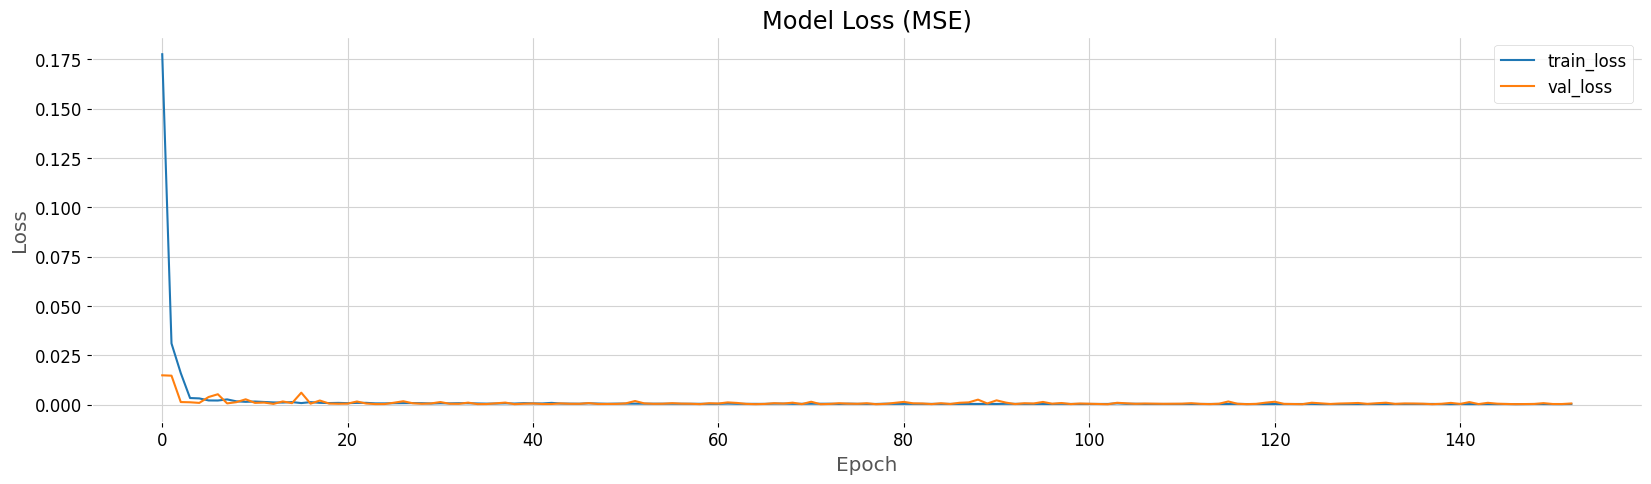

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

100/192 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step


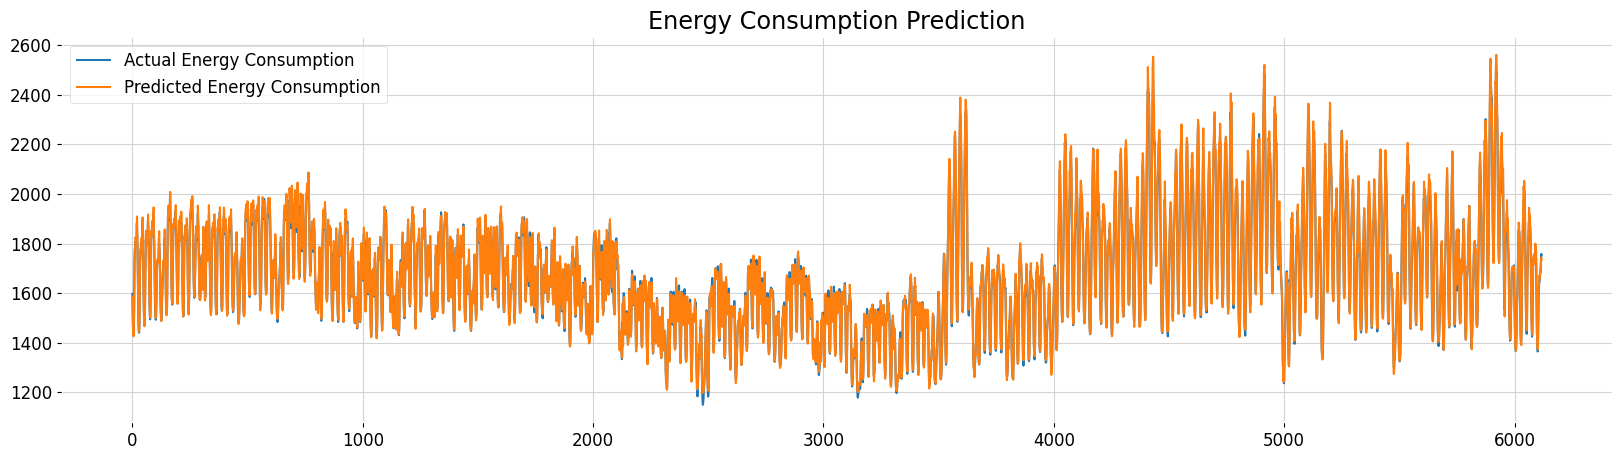

In [56]:
#train set performance
y_train_pred = model.predict(X_train)
predicted_energy = scaler.inverse_transform(y_train_pred)
actual_energy = scaler.inverse_transform(y_train.reshape(-1, 1))

# plt.figure(figsize=(10, 6))
plt.plot(actual_energy, label='Actual Energy Consumption')
plt.plot(predicted_energy, label='Predicted Energy Consumption')
plt.title('Energy Consumption Prediction')
plt.legend()

# Save the plot
plot_path = MODELS_DIR / 'prediction_vs_actual.png'
plt.savefig(plot_path)

# Show the plot
plt.show()

# Close the plot to free memory
plt.close()


In [57]:
train_loss, train_mae = model.evaluate(X_train, y_train)
print(f"Train Loss: {train_loss}")
print(f"Train MAE: {train_mae}")

110/192 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.1539e-04 - mean_absolute_error: 0.0111

192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 2.3224e-04 - mean_absolute_error: 0.0114
Train Loss: 0.00029575516236945987
Train MAE: 0.012591006234288216


In [58]:
# in original units
mae = mean_absolute_error(actual_energy, predicted_energy)
rmse = np.sqrt(mean_squared_error(actual_energy, predicted_energy))
print('mae: ', mae)
print('rmse: ', rmse)

mae:  17.300039889337814
rmse:  23.629412021308493


In [59]:
mape = np.abs((actual_energy - predicted_energy) / actual_energy).mean() * 100
print('MAPE: ', mape)

MAPE:  1.0060875385964165


In [60]:
# Reshape to (6118, 24)
X_flat = X_train.reshape(X_train.shape[0], X_train.shape[1])
df = pd.DataFrame(X_flat)


In [57]:
df.head()

,demand
date,
2024-01-01 04:00:00+00:00,1516
2024-01-01 05:00:00+00:00,1450
2024-01-01 06:00:00+00:00,1384
2024-01-01 07:00:00+00:00,1351
2024-01-01 08:00:00+00:00,1335


In [62]:
#in order to save to model for model registoy we have to create scema first
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [63]:
mr = project.get_model_registry()

In [64]:
model_pred = mr.python.create_model(
    name="electricity_demand_predictor_next_24h",
    metrics={"test_mae": mae},
    version=1,
    description="Transformer model for next 24-hour power demand prediction",
    input_example=df.sample(),
    model_schema=model_schema
)

# Save the model by pointing to the directory containing all artifacts
model_pred.save(str(MODELS_DIR))

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /teamspace/studios/this_studio/models/minmax_scaler.pkl: 0.000%|          | 0/1023 elapsed<00:00 rem…

Uploading /teamspace/studios/this_studio/models/prediction_vs_actual.png: 0.000%|          | 0/215383 elapsed<…

Uploading /teamspace/studios/this_studio/models/transformer_model.keras: 0.000%|          | 0/6343537 elapsed<…

Uploading /teamspace/studios/this_studio/input_example.json: 0.000%|          | 0/488 elapsed<00:00 remaining<…

Uploading /teamspace/studios/this_studio/model_schema.json: 0.000%|          | 0/217 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1222815/models/electricity_demand_predictor_next_24h/1


Model(name: 'electricity_demand_predictor_next_24h', version: 1)

In [2]:
from tensorflow.keras.models import load_model

2025-04-11 14:37:59.593826: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-11 14:37:59.603290: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 14:37:59.660050: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 14:37:59.711241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744382279.756203    3314 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744382279.76

In [11]:
model_path = "models/transformer_model.keras"
scaler_path = "models/minmax_scaler.pkl"

# Load the model and scaler
model = load_model(model_path, custom_objects={'PositionalEncoding': PositionalEncoding})
scaler = joblib.load(scaler_path)

In [58]:
test_set.head()

,demand,demand_scaled
date,,
2024-11-06 22:00:00+00:00,1869,0.524017
2024-11-06 23:00:00+00:00,1919,0.560408
2024-11-07 00:00:00+00:00,1901,0.547307
2024-11-07 01:00:00+00:00,1862,0.518923
2024-11-07 02:00:00+00:00,1811,0.481805


In [59]:
n_steps=24

In [60]:
time_steps = 24

In [61]:
# Initialize input data
if isinstance(test_set, pd.DataFrame):
    working_data = scaler.transform(test_set[['demand']].values)
else:
    working_data = scaler.transform(test_set.reshape(-1, 1))
            
working_data = working_data.flatten()

In [62]:
# Store predictions
predictions = []
        
# Predict n steps ahead
for _ in range(n_steps):
    # Use the last time_steps points for prediction
    sequence = working_data[-time_steps:]
    X = np.reshape(sequence, (1, time_steps, 1))
            
    # Make prediction
    next_scaled_value = model.predict(X, verbose=0)[0][0]
            
    # Add to working data for next iteration
    working_data = np.append(working_data, next_scaled_value)
            
    # Store prediction after inverse scaling
    prediction = scaler.inverse_transform([[next_scaled_value]])[0][0]
    predictions.append(prediction)       
        
        

In [63]:
predictions

[1991.3333805799484,
 2036.677827000618,
 2091.2000362873077,
 2135.469587445259,
 2147.4234874248505,
 2127.093921661377,
 2088.029484272003,
 2029.114659190178,
 1943.4118062257767,
 1833.3475270271301,
 1731.8308968544006,
 1663.221785902977,
 1614.709735751152,
 1579.1579332351685,
 1560.1339659690857,
 1559.257629454136,
 1582.940049469471,
 1648.3992054462433,
 1735.260119855404,
 1809.966323375702,
 1867.526084303856,
 1920.5260781049728,
 1992.332767009735,
 2086.353630423546]

In [ ]:
def predict_next_n_steps(self, recent_data, n_steps=24):
        """
        Predict multiple steps ahead
        
        Parameters:
        -----------
        recent_data : pd.DataFrame or np.array
            Recent demand data (at least time_steps points)
        n_steps : int
            Number of future steps to predict
            
        Returns:
        --------
        np.array
            Array of predicted values
        """
        if self.scaler is None:
            raise ValueError("Scaler not initialized. Call fit_scaler first.")
            
        # Initialize input data
        if isinstance(recent_data, pd.DataFrame):
            working_data = self.scaler.transform(recent_data[['demand']].values)
        else:
            working_data = self.scaler.transform(recent_data.reshape(-1, 1))
            
        working_data = working_data.flatten()
        
        # Store predictions
        predictions = []
        
        # Predict n steps ahead
        for _ in range(n_steps):
            # Use the last time_steps points for prediction
            sequence = working_data[-self.time_steps:]
            X = np.reshape(sequence, (1, self.time_steps, 1))
            
            # Make prediction
            next_scaled_value = self.model.predict(X, verbose=0)[0][0]
            
            # Add to working data for next iteration
            working_data = np.append(working_data, next_scaled_value)
            
            # Store prediction after inverse scaling
            prediction = self.scaler.inverse_transform([[next_scaled_value]])[0][0]
            predictions.append(prediction)
            
        return np.array(predictions)